# **Optimizing Partial AUC Loss on Imbalanaced Dataset**

**Authors**: Zhuoning Yuan, Dixian Zhu, Gang Li

**Introduction**

In this tutorial, you will learn how to quickly train a ResNet18 model by optimizing **Partial AUC (pAUC)** score using our novel optimization methods on a binary image classification task on Cifar10. This is a **wrapper** of original implementations of partial AUC losses. For original tutorials, please refer to [SOPA](https://github.com/Optimization-AI/LibAUC/blob/main/examples/11_Optimizing_pAUC_Loss_with_SOPA_on_Imbalanced_data.ipynb), [SOPA-s](https://github.com/Optimization-AI/LibAUC/blob/main/examples/11_Optimizing_pAUC_Loss_with_SOPAs_on_Imbalanced_data.ipynb), [SOTA-s](https://github.com/Optimization-AI/LibAUC/blob/main/examples/11_Optimizing_pAUC_Loss_with_SOTAs_on_Imbalanced_data.ipynb). After completion of this tutorial, you should be able to use LibAUC to train your own models on your own datasets.

**Useful Resources**

* Website: https://libauc.org
* Github: https://github.com/Optimization-AI/LibAUC


**References**

If you find this tutorial helpful in your work,  please acknowledge our library and cite the following papers:

<pre>
@article{zhu2022auc,
  title={When AUC meets DRO: Optimizing Partial AUC for Deep Learning with Non-Convex Convergence Guarantee},
  author={Zhu, Dixian and Li, Gang and Wang, Bokun and Wu, Xiaodong and Yang, Tianbao},
  journal={arXiv preprint arXiv:2203.00176},
  year={2022}
}
</pre>

## **Installing LibAUC**

Let's start with install our library here. In this tutorial, we will use beta version `1.1.9rc4`.

In [ ]:
!pip install libauc==1.1.9rc4

## **Importing LibAUC**

Import required libraries to use




In [ ]:
from libauc.models import resnet18
from libauc.datasets import CIFAR10
from libauc.losses.auc import pAUCLoss  # default: SOPA
from libauc.optimizers import SOPA
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler  # data resampling (for binary class)
from libauc.metrics import pauc_roc_score

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import Dataset
import torch 

import warnings
warnings.filterwarnings("ignore")

## **Reproducibility**

These functions limit the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [ ]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## **Image Dataset**


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip`. The `pos_index_map` helps map global index to local index for reducing memory cost in loss function since we only need to track the indices for positive samples. Please refer to original paper [here](https://arxiv.org/pdf/2203.00176.pdf) for more details.




In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
       
       # for loss function
       self.pos_indices = np.flatnonzero(targets==1)
       self.pos_index_map = {}
       for i, idx in enumerate(self.pos_indices):
           self.pos_index_map[idx] = i

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            idx = self.pos_index_map[idx] if idx in self.pos_indices else -1
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target, int(idx)

## **Hyper-parameters**

In [ ]:
# general params
lr = 1e-3
weight_decay = 5e-4
total_epoch = 60
decay_epochs = [20, 40]
batch_size = 64

# By default, we use one-way partial AUC loss (SOPA)
alpha = 0.  # a: min_tpr=0. This is fixed (for reference only)
beta = 0.1  # b: max_fpr=0.1

# By default, pAUCLoss calls SOPA in the backend
margin = 1.0
eta = 1e1 # learning rate for control negative samples weights

# sampling parameters
sampling_rate = 0.5
num_pos = int(batch_size*sampling_rate)
num_neg = int(batch_size*(1-sampling_rate))

## **Loading datasets**

In this step, , we will use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) as benchmark dataset. Before importing data to `dataloader`, we construct imbalanced version for CIFAR10 by `ImbalancedDataGenerator`. Specifically, it first randomly splits the training data by class ID (e.g., 10 classes) into two even portions as the positive and negative classes, and then it randomly removes some samples from the positive class to make
it imbalanced. We keep the testing set untouched. We refer `imratio` to the ratio of number of positive examples to number of all examples. 

In [ ]:
train_data, train_targets = CIFAR10(root='./data', train=True)
test_data, test_targets  = CIFAR10(root='./data', train=False)

imratio = 0.2
generator = ImbalancedDataGenerator(shuffle=True, verbose=True, random_seed=0)
(train_images, train_labels) = generator.transform(train_data, train_targets, imratio=imratio)
(test_images, test_labels) = generator.transform(test_data, test_targets, imratio=0.5) 

trainDataset = ImageDataset(train_images, train_labels)
testDataset = ImageDataset(test_images, test_labels, mode='test')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
#SAMPLES: [31250], POS:NEG: [6250 : 25000], POS RATIO: 0.2000
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


Now, we can import data and load the dataset!

In [ ]:
trainSet = ImageDataset(train_images, train_labels)
testSet = ImageDataset(test_images, test_labels, mode='test')

sampler = DualSampler(trainSet, batch_size, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size,  sampler=sampler,  shuffle=False,  num_workers=1)
testloader = torch.utils.data.DataLoader(testSet , batch_size=batch_size, shuffle=False, num_workers=1)

## **Model and Loss setup**
For `pAUCLoss`, you can set `backend` to `SOPAs`, `SOPA`, `SOTAs`. Here is the brief summary for each loss below. For more details regarding the parameters, please refer to the original tutorials. 


- **SOPA** [[Tutorial](https://github.com/Optimization-AI/LibAUC/blob/main/examples/11_Optimizing_pAUC_Loss_with_SOPA_on_Imbalanced_data.ipynb)]
```
Loss_fn = pAUC_CVaR_Loss(pos_length=sampler.pos_len, num_neg=num_neg, beta=beta)
optimizer = SOPA(model, loss_fn=loss_fn, mode='adam', lr=lr, eta=eta, weight_decay=weight_decay)
```

- **SOPAs** [[Tutorial](https://github.com/Optimization-AI/LibAUC/blob/main/examples/11_Optimizing_pAUC_Loss_with_SOPAs_on_Imbalanced_data.ipynb)]
```
loss_fn = pAUC_DRO_Loss(pos_len=sampler.pos_len, margin=margin, beta=beta, Lambda=Lambda)
optimizer = SOPAs(model, loss_fn=loss_fn, mode='adam', lr=lr, weight_decay=weight_decay)
```

- **SOTAs** [[Tutorial](https://github.com/Optimization-AI/LibAUC/blob/main/examples/11_Optimizing_pAUC_Loss_with_SOTAs_on_Imbalanced_data.ipynb)]
```
Loss_fn = tpAUC_KL_Loss(pos_len=sampler.pos_len, Lambda=Lambda, tau=tau)
optimizer = SOTAs(model, loss_fn=loss_fn, mode='adam', lr=lr, gammas=(gamma0, gamma1), weight_decay=weight_decay) 
```

In [ ]:
seed = 123
set_all_seeds(seed)
model = resnet18(pretrained=False, num_classes=1, last_activation=None) 
model = model.cuda()

loss_fn = pAUCLoss(pos_len=sampler.pos_len, backend='SOPA', beta=beta, num_neg=num_neg, margin=margin)
optimizer = SOPA(model.parameters(), loss_fn=loss_fn.loss_fn, mode='adam', lr=lr, eta=eta, weight_decay=weight_decay)

Backend loss: SOPA


## **Training**

Now we start training the model. We evaluate partial AUC performance with True Positive Rate (TPR) equal to 0 (`alpha=0`) and False Positive Rate (FPR) less than or equal to 0.3 (`beta=0.3`). This can be done by `libauc.metrics.pauc_roc_score(y_true, y_pred, max_fpr=0.3, min_tpr=0)`.

In [ ]:
print ('Start Training')
print ('-'*30)
test_best = 0
train_list, test_list = [], []
for epoch in range(total_epoch):
    
    if epoch in decay_epochs:
        optimizer.update_lr(decay_factor=10, coef_decay_factor=10)
            
    train_pred, train_true = [], []
    model.train() 
    for idx, (data, targets, index) in enumerate(trainloader):
        data, targets  = data.cuda(), targets.cuda()
        y_pred = model(data)
        y_prob = torch.sigmoid(y_pred)
        loss = loss_fn(y_prob, targets, index_p=index) # Notes: make index>0 for positive samples, and index<0 for negative samples
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_pred.append(y_prob.cpu().detach().numpy())
        train_true.append(targets.cpu().detach().numpy())

    train_true = np.concatenate(train_true)
    train_pred = np.concatenate(train_pred)
    train_pauc = pauc_roc_score(train_true, train_pred, max_fpr=0.3)
    train_list.append(train_pauc)
    
   # evaluation
    model.eval()
    test_pred, test_true = [], [] 
    for j, data in enumerate(testloader):
        test_data, test_targets, index = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_prob = torch.sigmoid(y_pred)
        test_pred.append(y_prob.cpu().detach().numpy())
        test_true.append(test_targets.numpy())
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    val_pauc = pauc_roc_score(test_true, test_pred, max_fpr=0.3)
    test_list.append(val_pauc)
    
    if test_best < val_pauc:
       test_best = val_pauc
    
    model.train()
    print("epoch: %s, lr: %.4f, train_pauc: %.4f, test_pauc: %.4f, test_best: %.4f"%(epoch, optimizer.lr, train_pauc, val_pauc, test_best))
    

Start Training
------------------------------
epoch: 0, lr: 0.0010, train_pauc: 0.5866, test_pauc: 0.6762, test_best: 0.6762
epoch: 1, lr: 0.0010, train_pauc: 0.7000, test_pauc: 0.6953, test_best: 0.6953
epoch: 2, lr: 0.0010, train_pauc: 0.7493, test_pauc: 0.7482, test_best: 0.7482
epoch: 3, lr: 0.0010, train_pauc: 0.7887, test_pauc: 0.7729, test_best: 0.7729
epoch: 4, lr: 0.0010, train_pauc: 0.8212, test_pauc: 0.7831, test_best: 0.7831
epoch: 5, lr: 0.0010, train_pauc: 0.8418, test_pauc: 0.7716, test_best: 0.7831
epoch: 6, lr: 0.0010, train_pauc: 0.8592, test_pauc: 0.8243, test_best: 0.8243
epoch: 7, lr: 0.0010, train_pauc: 0.8738, test_pauc: 0.8082, test_best: 0.8243
epoch: 8, lr: 0.0010, train_pauc: 0.8922, test_pauc: 0.8251, test_best: 0.8251
epoch: 9, lr: 0.0010, train_pauc: 0.9005, test_pauc: 0.8165, test_best: 0.8251
epoch: 10, lr: 0.0010, train_pauc: 0.9173, test_pauc: 0.8308, test_best: 0.8308
epoch: 11, lr: 0.0010, train_pauc: 0.9269, test_pauc: 0.8402, test_best: 0.8402
epoc

# **Visualization**

Now, let's see the change of one-way partial AUC scores on training and testing set. We take the `AUC-M` method as a comparison. For more details and tutorials about `AUCM Loss`, please refer to [AUC-M](https://github.com/Optimization-AI/LibAUC/blob/main/examples/02_Optimizing_AUROC_with_ResNet20_on_Imbalanced_CIFAR10.ipynb).

Text(0.5, 0, 'epochs')

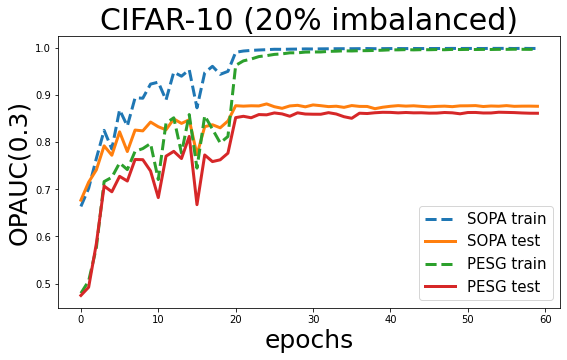

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(60)
aucm_tr_pAUC = [0.6429585593723751, 0.705619972966429, 0.69894917006115, 0.7947875283260033, 0.7677915794870532, 0.7694341408326258, 0.8345354696048994, 0.8353778185042913, 0.8261352422411384, 0.850143596501959, 0.8749833709434203, 0.8778469862659533, 0.8833579163047021, 0.8755243973017512, 0.874157483715067, 0.8366073362501383, 0.8920074624226216, 0.8941630657880417, 0.8697558150194012, 0.8712549503124775, 0.9686330493047073, 0.9769933546518772, 0.9815388471447516, 0.9843683141845079, 0.9862415423489106, 0.9870076275453813, 0.9891961884708532, 0.9900528747015318, 0.9912304734205963, 0.9912435867529628, 0.9929736720264557, 0.9928194070381502, 0.9935700668345326, 0.9933461158425558, 0.9939052576360476, 0.9946626137958484, 0.9945831000132086, 0.9943817922164405, 0.9950893414460829, 0.9952917756106698, 0.9958267789776483, 0.9955192943758522, 0.9957648139930699, 0.9957864767962223, 0.9961289076816299, 0.99591124055382, 0.9961174449741217, 0.9958902131376424, 0.996271318496243, 0.9960302217876651, 0.9959968608322265, 0.995976135413218, 0.9958279797460171, 0.9962699055136474, 0.9961840783577622, 0.996047774666769, 0.9964594341651255, 0.9964745506616648, 0.9960480697575578, 0.996416429077646]
aucm_te_pAUC = [0.6279169411764706, 0.696358431372549, 0.673276862745098, 0.7493461960784313, 0.7261282745098039, 0.7153201960784313, 0.7762015294117646, 0.781920274509804, 0.778698862745098, 0.773890431372549, 0.8124459607843137, 0.802709294117647, 0.8055946274509804, 0.8052427843137255, 0.8037347843137256, 0.789566862745098, 0.8226527450980392, 0.819271725490196, 0.8068901176470589, 0.8064509019607844, 0.8594197647058823, 0.8614054901960784, 0.8630056862745098, 0.8605498823529412, 0.8648399607843138, 0.8607361176470588, 0.8658290196078431, 0.8603041176470588, 0.8643641960784314, 0.8594430588235293, 0.8661986274509804, 0.8604558823529411, 0.8617808235294118, 0.8613043529411765, 0.8562662352941177, 0.859865137254902, 0.8595644705882353, 0.865197294117647, 0.858666862745098, 0.8554585490196078, 0.8611540392156862, 0.8627088627450981, 0.8615218823529411, 0.8601713725490197, 0.8619247450980392, 0.8619268627450981, 0.8633670196078431, 0.8617367058823528, 0.8618482352941177, 0.859918, 0.8597246666666667, 0.860948705882353, 0.8607091372549018, 0.8608580784313726, 0.8610979215686274, 0.8626889803921569, 0.8603958039215687, 0.8605810980392157, 0.8616598039215686, 0.8612713725490196]
plt.figure()
plt.plot(x, train_list, LineStyle='--', label='SOPA train', linewidth=3)
plt.plot(x, test_list, label='SOPA test', linewidth=3)
plt.plot(x, aucm_tr_pAUC, LineStyle='--', label='PESG train', linewidth=3)
plt.plot(x, aucm_te_pAUC, label='PESG test', linewidth=3)
plt.title('CIFAR-10 (20% imbalanced)',fontsize=30)
plt.legend(fontsize=15)
plt.ylabel('OPAUC(0.3)',fontsize=25)
plt.xlabel('epochs',fontsize=25)